# This file will show evaluation for both LORA and without LORA

We took inferecne from our dataset here. https://www.kaggle.com/datasets/subbhashit/preprocessed

In [67]:
import numpy as np 
import pandas as pd 
import os

In [68]:
import os
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datasets import load_dataset, set_caching_enabled
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from transformers import (
    AutoTokenizer, AutoFeatureExtractor,
    AutoModel, AutoConfig,  
    TrainingArguments, Trainer,
    logging
)
import warnings 
warnings.filterwarnings('ignore')

import nltk
nltk.download('wordnet')
import nltk
import subprocess
import safetensors
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

from nltk.corpus import wordnet
from sklearn.metrics import accuracy_score, f1_score

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /kaggle/working/corpora/wordnet.zip


replace /kaggle/working/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

cuda
Tesla P100-PCIE-16GB


In [71]:
dataset = load_dataset(
    "csv", 
    data_files={
        "train": "/kaggle/input/preprocessed/processed/data_train.csv",
        "test": "/kaggle/input/preprocessed/processed/data_eval.csv"
    }
)

with open("/kaggle/input/preprocessed/processed/answer_space.txt") as f:
    answer_space = f.read().splitlines()

dataset = dataset.map(
    lambda examples: {
        'label': [
            answer_space.index(ans.replace(" ", "").split(",")[0])  # select the 1st answer if multiple answers are provided
            for ans in examples['answer']
        ]
    },
    batched=True
)

In [72]:
@dataclass
class MultimodalCollator:
    tokenizer: AutoTokenizer
    preprocessor: AutoFeatureExtractor
    
    def tokenize_text(self, texts: List[str]) -> Dict[str, torch.Tensor]:
        encoded_text = self.tokenizer(
            text=texts,
            padding='longest',
            max_length=24,
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
        )
        return {
            "input_ids": encoded_text['input_ids'].squeeze(),
            "token_type_ids": encoded_text['token_type_ids'].squeeze(),
            "attention_mask": encoded_text['attention_mask'].squeeze(),
        }
    
    def preprocess_images(self, images: List[str]) -> Dict[str, torch.Tensor]:
        processed_images = self.preprocessor(
            images=[
                Image.open(os.path.join("/kaggle/input/preprocessed/processed/images/", f"{image_id}.png")).convert('RGB')
                for image_id in images
            ],
            return_tensors="pt",
        )
        return {
            "pixel_values": processed_images['pixel_values'].squeeze(),
        }
            
    def __call__(self, raw_batch_dict) -> Dict[str, torch.Tensor]:
        question_batch = raw_batch_dict['question'] if isinstance(raw_batch_dict, dict) else [i['question'] for i in raw_batch_dict]
        image_id_batch = raw_batch_dict['image_id'] if isinstance(raw_batch_dict, dict) else [i['image_id'] for i in raw_batch_dict]
        label_batch = raw_batch_dict['label'] if isinstance(raw_batch_dict, dict) else [i['label'] for i in raw_batch_dict]

        return {
            **self.tokenize_text(question_batch),
            **self.preprocess_images(image_id_batch),
            'labels': torch.tensor(label_batch, dtype=torch.int64),
        }


In [73]:
def wup_measure(a, b, similarity_threshold=0.925):
    def get_semantic_field(word):
        weight = 1.0
        semantic_field = wordnet.synsets(word, pos=wordnet.NOUN)
        return semantic_field, weight

    def get_stem_word(word):
        weight = 1.0
        return word, weight

    global_weight = 1.0
    a, global_weight_a = get_stem_word(a)
    b, global_weight_b = get_stem_word(b)
    global_weight = min(global_weight_a, global_weight_b)
    if a == b:
        return 1.0 * global_weight
    if a == "" or b == "":
        return 0
    interp_a, weight_a = get_semantic_field(a)
    interp_b, weight_b = get_semantic_field(b)
    if interp_a == [] or interp_b == []:
        return 0
    global_max = 0.0
    for x in interp_a:
        for y in interp_b:
            local_score = x.wup_similarity(y)
            if local_score > global_max:
                global_max = local_score
    if global_max < similarity_threshold:
        interp_weight = 0.1
    else:
        interp_weight = 1.0

    final_score = global_max * weight_a * weight_b * interp_weight * global_weight
    return final_score

def batch_wup_measure(labels, preds):
    wup_scores = [wup_measure(answer_space[label], answer_space[pred]) for label, pred in zip(labels, preds)]
    return np.mean(wup_scores)


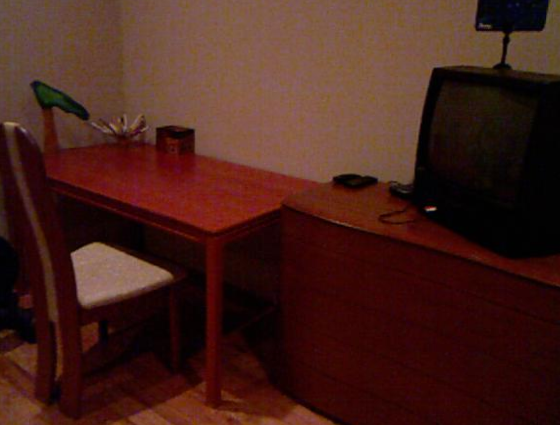

Question:	 what is the large black object
Answer:		 television (Label: 493)


'television'

In [75]:
import IPython.display as display

def show_example(train=True, idx=None):
    dataset_type = "train" if train else "test"
    data = dataset[dataset_type]

    if idx is None:
        idx = np.random.randint(len(data))

    image_path =  "/kaggle/input/preprocessed/processed/images/"+ f"{data[idx]['image_id']}.png"
    image = Image.open(image_path)
    display.display(image)

    question = data[idx]["question"]
    answer = data[idx]["answer"]
    label = data[idx]["label"]

    print(f"Question:\t {question}")
    print(f"Answer:\t\t {answer} (Label: {label})")

    return answer
show_example()

In [76]:
labels = np.random.randint(len(answer_space), size=5)
preds = np.random.randint(len(answer_space), size=5)

def showAnswers(ids):
    print([answer_space[id] for id in ids])

showAnswers(labels)
showAnswers(preds)

print("Predictions vs Labels: ", batch_wup_measure(labels, preds))
print("Labels vs Labels: ", batch_wup_measure(labels, labels))

['telescope', 'water_heater', 'curtain', 'ipad', 'display_board']
['spoon', 'piano_bench', 'vegetable', 'napkin_dispenser', 'rug']
Predictions vs Labels:  0.03485380116959065
Labels vs Labels:  1.0


# For LORA

In [77]:
class MultimodalVQAModel(nn.Module):
    def __init__(
        self,
        num_labels: int = len(answer_space),
        intermediate_dim: int = 512,
        pretrained_text_name: str = 'bert-base-uncased',
        pretrained_image_name: str = 'facebook/deit-base-distilled-patch16-224'
    ):
        super(MultimodalVQAModel, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name
        self.text_encoder = AutoModel.from_pretrained(self.pretrained_text_name)
        self.image_encoder = AutoModel.from_pretrained(self.pretrained_image_name)
        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        self.classifier = nn.Linear(intermediate_dim, self.num_labels)
        self.criterion = nn.CrossEntropyLoss()

    def forward(
        self,
        input_ids: torch.LongTensor,
        pixel_values: torch.FloatTensor,
        attention_mask: Optional[torch.LongTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        labels: Optional[torch.LongTensor] = None
    ):
        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )
        fused_output = self.fusion(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    encoded_image['pooler_output'],
                ],
                dim=1
            )
        )
        logits = self.classifier(fused_output)
        
        out = {"logits": logits}
        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss
        
        return out

In [78]:
from typing import Tuple, Dict
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(eval_tuple: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:
    
    logits, labels = eval_tuple
    preds = logits.argmax(axis=-1)
    metrics = {
        "wups": batch_wup_measure(labels, preds),
        "acc": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='macro'),
        "precision": precision_score(labels, preds, average='macro'),
        "recall": recall_score(labels, preds, average='macro')
    }

    return metrics


## Text Models : 

Bert : bert-base-uncased

Roberta : roberta-base

## Image Models :

ViT : google/vit-base-patch16-224

DeIT : facebook/deit-base-distilled-patch16-224

BeIT : microsoft/beit-base-patch16-224-pt22k-ft22k

You can use any combo here by replacing text_model and image_model here and upload the corresponding file

In [79]:
model = MultimodalVQAModel(pretrained_text_name="roberta-base",pretrained_image_name="microsoft/beit-base-patch16-224-pt22k-ft22k",num_labels=len(answer_space))
model.load_state_dict(torch.load('/kaggle/input/roberta/Roberta_BeIT_weights.pth'))
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MultimodalVQAModel(
  (text_encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNo

# RANDOMLY SELECTED 10 INDICES FROM TEST DATA

In [80]:
def create_multimodal_vqa_collator(text_encoder='bert-base-uncased', image_encoder='facebook/deit-base-distilled-patch16-224'):
    tokenizer = AutoTokenizer.from_pretrained(text_encoder)
    preprocessor = AutoFeatureExtractor.from_pretrained(image_encoder)
    multimodal_collator = MultimodalCollator(
        tokenizer=tokenizer,
        preprocessor=preprocessor,
    )

    return multimodal_collator

collator = create_multimodal_vqa_collator()

In [81]:
import random

random_sample_indices = random.sample(range(len(dataset["test"])), k=10)

sample = collator([dataset["test"][index] for index in random_sample_indices])

input_ids = sample["input_ids"].to(device)
token_type_ids = sample["token_type_ids"].to(device)
attention_mask = sample["attention_mask"].to(device)
pixel_values = sample["pixel_values"].to(device)
labels = sample["labels"].to(device)

In [82]:
model.eval()
output = model(input_ids, pixel_values, attention_mask, token_type_ids, labels)

In [83]:
predictions = output["logits"].argmax(axis=-1).cpu().numpy()
predictions

array([ 43, 106, 568,  10, 150,  81, 176, 150, 236,  10])

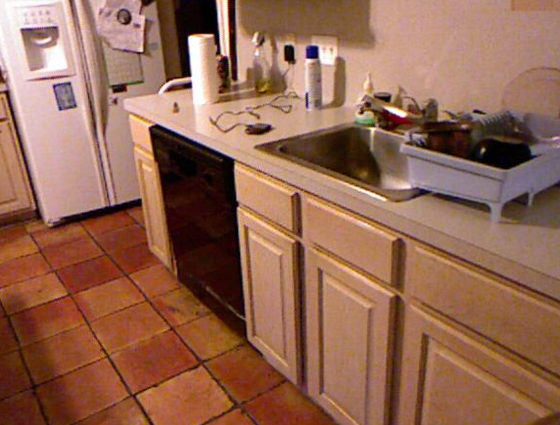

Question:	 what is on the left side of the container
Answer:		 bottle_of_hand_wash_liquid (Label: 64)
Predicted Answer:	 spoon
Similarity: 0.47869981325863675






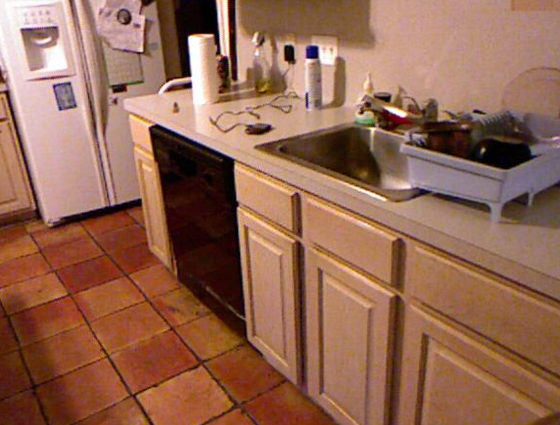

Question:	 what is on the right side of the tap
Answer:		 kitchen_utensils (Label: 301)
Predicted Answer:	 piano_bench
Similarity: 0.5964912280701754






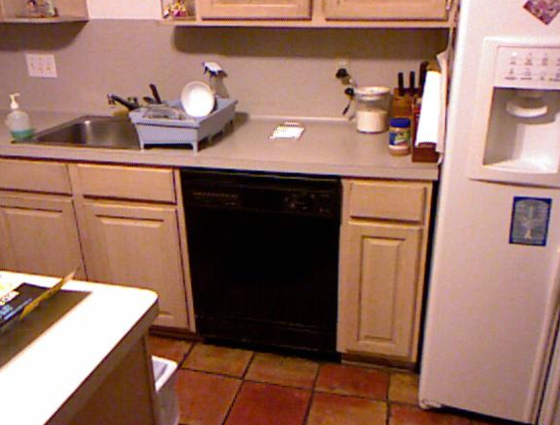

Question:	 what is on the right side of the cellphone charger
Answer:		 plastic_box (Label: 393)
Predicted Answer:	 vegetable
Similarity: 0.4666666666666667






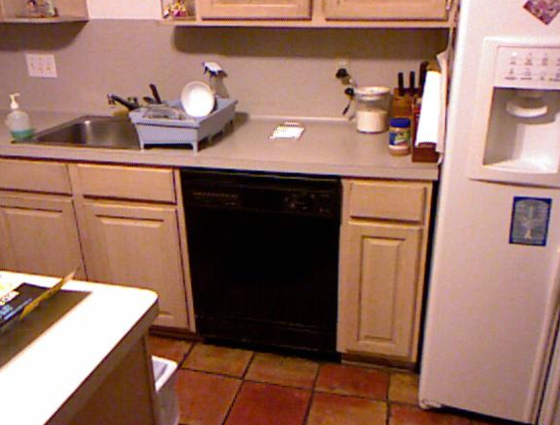

Question:	 what is on the right side of the plastic box
Answer:		 knife_rack, knife (Label: 303)
Predicted Answer:	 napkin_dispenser
Similarity: 0.526300085251492






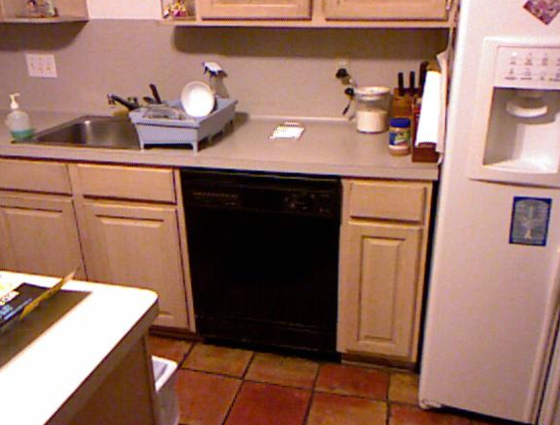

Question:	 what is behind the kitchen utensils
Answer:		 bottle_of_liquid (Label: 65)
Predicted Answer:	 rug
Similarity: 0.4957983193277311




In [84]:
from nltk.corpus import wordnet

def similarity(a, b):
    words_a = [w.strip() for w in a.split(',')]
    words_b = [w.strip() for w in b.split(',')]
    a = [w_ for word in words_a for w_ in word.split('_')]
    b = [w_ for word in words_b for w_ in word.split('_')]

    res = 0
    n = 0
    for i in a:
        synsets_i = wordnet.synsets(i)
        if synsets_i:
            s1 = synsets_i[0]
            for j in b:
                synsets_j = wordnet.synsets(j)
                if synsets_j:
                    s2 = synsets_j[0]
                    sim = s1.wup_similarity(s2)
                    if sim:
                        res += sim
                    n += 1

    return res / n if n != 0 else 0
for i in range(2000, 2005):
    print("\n=========================================================\n")
    real_answer = show_example(train=False, idx=i)
    predicted_answer = answer_space[preds[i - 2000]]
    print("Predicted Answer:\t", predicted_answer)
    print(f"Similarity: {similarity(real_answer, predicted_answer)}")
    print("\n=========================================================\n")


# With LORA

# Text Transformers

In [85]:
from transformers import RobertaConfig, RobertaModel
import torch.nn as nn

class LoRaRobertaModel(nn.Module):
    def __init__(self, model_name='roberta-base', rank=32, lora_alpha=32, lora_dropout=0.1):
        super(LoRaRobertaModel, self).__init__()
        self.config = RobertaConfig.from_pretrained(model_name)
        self.config.lora = True
        self.config.lora_rank = rank
        self.config.lora_alpha = lora_alpha
        self.config.lora_dropout = lora_dropout
        self.roberta = RobertaModel(self.config)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        return self.roberta(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

model = LoRaRobertaModel()

In [86]:
from transformers import BertConfig, BertModel
import torch.nn as nn

class LoRaBertModel(nn.Module):
    def __init__(self, model_name='bert-base-uncased', rank=16, lora_alpha=32, lora_dropout=0.1):
        super(LoRaBertModel, self).__init__()
        self.config = BertConfig.from_pretrained(model_name)
        self.config.lora = True
        self.config.lora_rank = rank
        self.config.lora_alpha = lora_alpha
        self.config.lora_dropout = lora_dropout
        self.bert = BertModel(self.config)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        return self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)



# Vision Transformers

In [87]:
from transformers import ViTConfig, ViTModel
import torch.nn as nn

class LoRaViTModel(nn.Module):
    def __init__(self, model_name='google/vit-base-patch16-224', rank=32, lora_alpha=32, lora_dropout=0.1):
        super(LoRaViTModel, self).__init__()
        self.config = ViTConfig.from_pretrained(model_name)
        self.config.lora = True
        self.config.lora_rank = rank
        self.config.lora_alpha = lora_alpha
        self.config.lora_dropout = lora_dropout
        self.vit = ViTModel(self.config)

    def forward(self, pixel_values, attention_mask=None):
        outputs = self.vit(pixel_values)
        return outputs


In [88]:
from transformers import DeiTConfig, DeiTModel
import torch.nn as nn

class LoRaDeiTModel(nn.Module):
    def __init__(self, model_name='facebook/deit-base-patch16-224', rank=32, lora_alpha=32, lora_dropout=0.1):
        super(LoRaDeiTModel, self).__init__()
        self.config = DeiTConfig.from_pretrained(model_name)
        self.config.lora = True
        self.config.lora_rank = rank
        self.config.lora_alpha = lora_alpha
        self.config.lora_dropout = lora_dropout
        self.deit = DeiTModel(self.config)

    def forward(self, pixel_values, attention_mask=None):
        outputs = self.deit(pixel_values)
        
        return outputs


In [89]:
from transformers import BeitConfig, BeitModel
class LoRaBeitModel(nn.Module):
    def __init__(self, model_name='microsoft/beit-base-patch16-224', rank=32, lora_alpha=32, lora_dropout=0.1):
        super(LoRaBeitModel, self).__init__()
        # Load the basic Beit model configuration
        self.config = BeitConfig.from_pretrained(model_name)
        # Modify configuration to include LoRa parameters
        self.config.lora = True
        self.config.lora_rank = rank
        self.config.lora_alpha = lora_alpha
        self.config.lora_dropout = lora_dropout
        self.beit = BeitModel(self.config)

    def forward(self, pixel_values, attention_mask=None):
        outputs = self.beit(pixel_values)
        return outputs

In [92]:
class MultimodalVQAModel(nn.Module):
    def __init__(self, num_labels, intermediate_dim=512,pretrained_text_name = 'bert-base-uncased', pretrained_image_name='google/vit-base-patch16-224-in21k',rank = 32):
        super(MultimodalVQAModel, self).__init__()
        self.num_labels = num_labels 
        self.text_encoder = LoRaBertModel(pretrained_text_name, rank=rank, lora_alpha=16, lora_dropout=0.1)
        self.image_encoder = LoRaBeitModel(pretrained_image_name, rank=rank, lora_alpha=16, lora_dropout=0.1)
        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        self.classifier = nn.Linear(intermediate_dim, self.num_labels)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, input_ids, pixel_values, attention_mask=None, token_type_ids=None, labels=None):
        text_output = self.text_encoder(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        image_output = self.image_encoder(pixel_values)
        fused_output = self.fusion(torch.cat([text_output.pooler_output, image_output.pooler_output], dim=1))
        logits = self.classifier(fused_output)
        output = {"logits": logits}
        if labels is not None:
            loss = self.criterion(logits, labels)
            output["loss"] = loss
        
        return output

In [93]:
model = MultimodalVQAModel(pretrained_text_name = 'bert-base-uncased',pretrained_image_name="microsoft/beit-base-patch16-224-pt22k-ft22k",num_labels=len(answer_space))
model.load_state_dict(torch.load('/kaggle/input/bert-beit-lora-64/Bert_BeIT_weights_lora_64_new.pth'))
model.to(device)

MultimodalVQAModel(
  (text_encoder): LoRaBertModel(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias

# Used collator here form the LORA part , make sure to run and check it

In [94]:
import random
random_sample_indices = random.sample(range(len(dataset["test"])), k=10)
sample = collator([dataset["test"][index] for index in random_sample_indices])
input_ids = sample["input_ids"].to(device)
token_type_ids = sample["token_type_ids"].to(device)
attention_mask = sample["attention_mask"].to(device)
pixel_values = sample["pixel_values"].to(device)
labels = sample["labels"].to(device)

In [95]:
model.eval()
output = model(input_ids, pixel_values, attention_mask, token_type_ids, labels)

In [96]:
predictions = output["logits"].argmax(axis=-1).cpu().numpy()
predictions

array([483, 483, 483,  10, 483, 483, 483, 483, 106, 483])

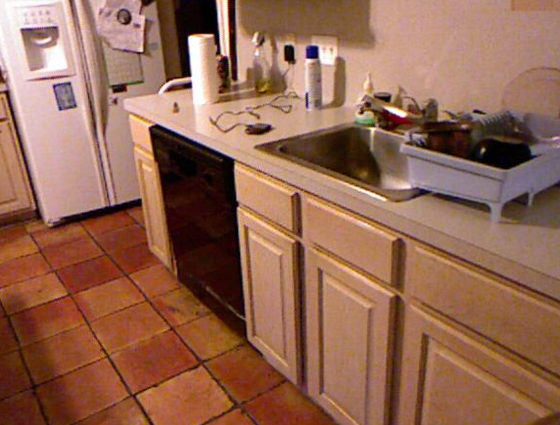

Question:	 what is on the left side of the container
Answer:		 bottle_of_hand_wash_liquid (Label: 64)
Predicted Answer:	 spoon
Similarity: 0.47869981325863675






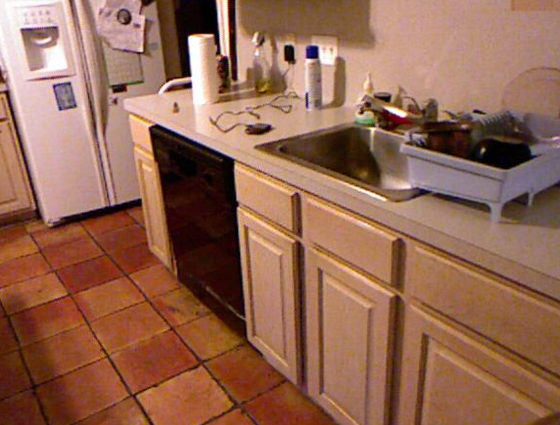

Question:	 what is on the right side of the tap
Answer:		 kitchen_utensils (Label: 301)
Predicted Answer:	 piano_bench
Similarity: 0.5964912280701754






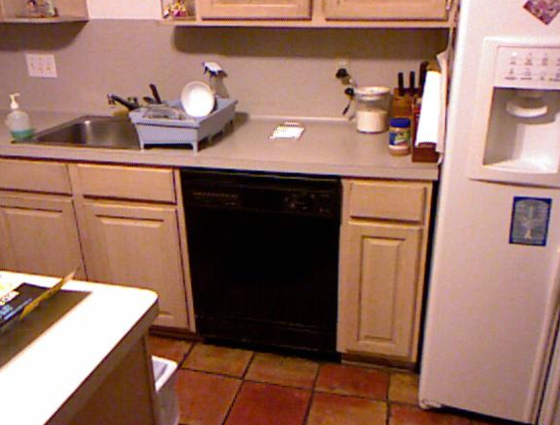

Question:	 what is on the right side of the cellphone charger
Answer:		 plastic_box (Label: 393)
Predicted Answer:	 vegetable
Similarity: 0.4666666666666667






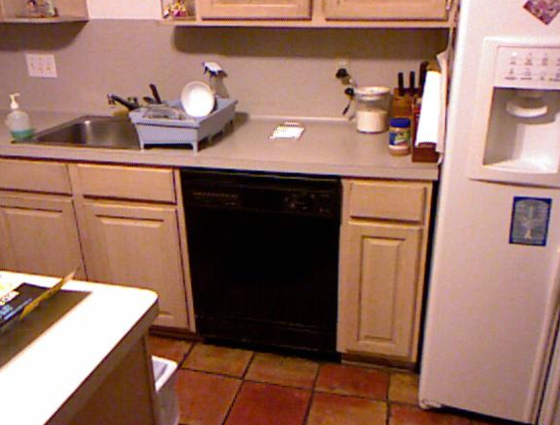

Question:	 what is on the right side of the plastic box
Answer:		 knife_rack, knife (Label: 303)
Predicted Answer:	 napkin_dispenser
Similarity: 0.526300085251492






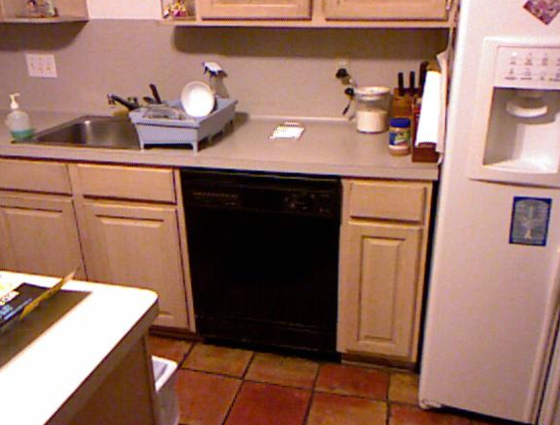

Question:	 what is behind the kitchen utensils
Answer:		 bottle_of_liquid (Label: 65)
Predicted Answer:	 rug
Similarity: 0.4957983193277311




In [97]:
from nltk.corpus import wordnet

def similarity(a, b):
    words_a = [w.strip() for w in a.split(',')]
    words_b = [w.strip() for w in b.split(',')]
    a = [w_ for word in words_a for w_ in word.split('_')]
    b = [w_ for word in words_b for w_ in word.split('_')]

    res = 0
    n = 0
    for i in a:
        synsets_i = wordnet.synsets(i)
        if synsets_i:
            s1 = synsets_i[0]
            for j in b:
                synsets_j = wordnet.synsets(j)
                if synsets_j:
                    s2 = synsets_j[0]
                    sim = s1.wup_similarity(s2)
                    if sim:
                        res += sim
                    n += 1

    return res / n if n != 0 else 0
for i in range(2000, 2005):
    print("\n=========================================================\n")
    real_answer = show_example(train=False, idx=i)
    predicted_answer = answer_space[preds[i - 2000]]
    print("Predicted Answer:\t", predicted_answer)
    print(f"Similarity: {similarity(real_answer, predicted_answer)}")
    print("\n=========================================================\n")
